# Data Science For Biology 2025 Final Project: Mutagenesis Development and Lead Protein Sequence Screening

## Libraries and Packages

In [22]:
!pip install metapredict


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [23]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import joblib
from tqdm import tqdm
import metapredict as meta
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

## Screen For ADseq with Low SCGlucose Activity
Here I will load in the data as usual, but this time, I will sort by Activity_SCglucose in ascending order to have easier access to ADseq's which express low activity

In [24]:
data = pd.read_csv("./data/gcn4-orthologs.csv")
data = data.rename(columns={data.columns[0]: "tile_id"})
data.head()

,tile_id,DNAseq,ADseq,numreads_per_AD_7AGFP_AAS,Activity_7AGFP_AAS,numreads_per_AD_8AmCh_AAS,Activity_8AmCh_AAS,numreads_per_AD_9ARatio_AAS,Activity_9ARatio_AAS,numreads_per_AD_10BRatio_AAS,...,Activity_BYS4_BioRepAverage,Stdev_BYS4_BioReps,Activity_SCglucose,Start,Recovered,Activity_SCgalactose,Activity_P3promoter,Activity_P14promoter,Activity_P15promoter,Activity_P3promoterMig1TFBSremoved
0,0,AAAAATTCTAGATTTGTTTCTTTGATGCAAGGATTCTCTGATGGTT...,KNSRFVSLMQGFSDGSKDIIDNEVREVGDFSVNKPPQADD,NaN,NaN,NaN,NaN,NaN,NaN,3151.0,...,NaN,NaN,11666.48682,341,True,97250.68362,NaN,11149.49032,NaN,8040.343648
1,1,AAAAATTCTCCATCTGGTTTGGCTCATTCTTCTGTTTCTGGTGTTG...,KNSPSGLAHSSVSGVGKSRRRKGPLPPITVQDPSDKTAIK,942.0,709.606092,367.0,2921.917252,601.0,22242.74698,6909.0,...,21968.05843,5849.143385,21968.05843,146,True,15516.96245,14570.13217,16872.28649,11555.08411,10255.296840
2,2,AAACAAAATTCTCAAGTTGATCAATCTCCATTGTTGCCAGAAGAAG...,KQNSQVDQSPLLPEEELEVSEHLRRRRSGTATSPPAGGVR,NaN,NaN,NaN,NaN,NaN,NaN,6577.0,...,NaN,NaN,21203.02478,326,True,0.00000,18274.98241,15702.60901,18303.29201,17265.783330
3,3,AAACAAAGAGCTACTCCATTGACTCCAGTTGTTCCAGAATCTGATG...,KQRATPLTPVVPESDDPVALKRARNTEAARRSRARKLERM,357.0,1039.469842,342.0,1089.428196,450.0,74251.36241,NaN,...,NaN,NaN,47244.41248,246,True,92844.00000,NaN,NaN,NaN,84807.518160
4,4,AAACAAAGATCTATTCCATTGTCTCCAATTGTTCCAGAATCTTCTG...,KQRSIPLSPIVPESSDPAALKRARNTEAARRSRARKLQRM,539.0,1081.980998,627.0,622.131501,586.0,58872.95132,128.0,...,95093.69451,13292.686710,95093.69451,211,True,76399.62949,NaN,125056.17980,129302.35080,100360.735500


In [ ]:
# Sort by activity
activity = "Activity_SCglucose"
low_activity_df = data.sort_values(by=[activity], ascending=True)
low_activity_df = low_activity_df[['ADseq', activity]].dropna()
low_activity_df


,ADseq,Activity_SCglucose
9175,DFVLFDSPQPQRTTVNRPSSVPSNSAAPFGSLQSNTTSTN,6138.0
9585,DDKAAGDSAPVDSAPALVKQPSTTPLDSPAPLIMDTYTRR,6138.0
3711,RKLERQDVMERRIAELEKSLEEAEQREQYWKAMAQAQTQV,6138.0
2712,TLAARKSRQRKMQRFEELEDQIAKLEAERDHWKEIALRRS,6138.0
8564,EAARRSRARKMERMNQLEDKVEDLVGEKQALQDEVDRLKS,6138.0
...,...,...
6161,HANRGPDFDALFDLTANSFVDGLDAASLAMFDTQQLDKVQ,262143.0
1541,TTFNNTQAQQEFPSIMSTSSIPQDFDALFDLTANSFVDGL,262143.0
11857,GTISPQDLMMDASAPPSASLTDLSTPSFESPGYFSQDPSP,262143.0
6726,PMFEFESLDESNDPKNWTSLFENDLPIITEDDVSLNDKAI,262143.0


In [26]:
# Let's look at the min and max values of the activity
low_activity_df.describe()

,Activity_SCglucose
count,18944.000000
mean,66087.894674
std,61869.279225
min,6138.000000
25%,24438.359877
50%,43490.494810
75%,77276.723883
max,262143.000000


## In Silico Directed Evolution
Without loss of generality, let's simply pick the protein sequence with the lowest activity and do some a random pointwise mutation. We then repeat this process across $N$ generations. First I will add sequence features so that we can use the random forest model to predict the SCGlucose activity. The reason for this is because the model is very strict with the columns we provide for prediction. It must be named and ordered exactly the same as how we trained the model initially or scikit-learn will complain!

In [27]:
# FEATURES

# variables I need glovally
AA_LIST = 'ACDEFGHIKLMNPQRSTVWY'
AA_COLS = [f"AA_{aa}" for aa in AA_LIST]

# I use Kyte-Doolittle scale for hydrophobicity hereee CHECK WITH PROF STALLER
# https://www.rbvi.ucsf.edu/chimera/docs/UsersGuide/midas/hydrophob.html
KD_HYDROPHOBICITY = {
    'A': 1.8, 'C': 2.5, 'D': -3.5, 'E': -3.5, 'F': 2.8,
    'G': -0.4, 'H': -3.2, 'I': 4.5, 'K': -3.9, 'L': 3.8,
    'M': 1.9, 'N': -3.5, 'P': -1.6, 'Q': -3.5, 'R': -4.5,
    'S': -0.8, 'T': -0.7, 'V': 4.2, 'W': -0.9, 'Y': -1.3
}

# i use the tuple here for naming the motifs
MOTIFS = [
    ("W..LF", "W..LF"),
    ("WFYL_WFYL", "[WFYL]..[WFYL][WFYL]"),
    ("WFL_WFL", "[WFL]..[WFL][WFL]"),
    ("DE_WFY", "[DE][WFY]"),
    ("DE_WF", "[DE][WF]"),
    ("DE_L", "[DE][L]"),
    ("DE_x_WFY", "[DE].[WFY]"),
    ("DE_xx_WFY", "[DE]..[WFY]"),
    ("FF", "FF"),
    ("F_F", "F.F"),
    ("F__F", "F..F"),
    ("FY_5x_FY", "[FY].....[FY]"),
    ("SP", "SP"),
    ("WFYL_3x_WFYL", "[WFYL]...[WFYL][WFYL]")
]

# FUNCTIONS TO CALC

def amino_acid_count(sequence: str) -> dict[str, int]:
    c = Counter(sequence)
    return {f"AA_{aa}": c.get(aa, 0) for aa in AA_LIST}

def net_charge(seq: str) -> int:
    charge_map = {"K": 1, "R": 1, "D": -1, "E": -1}
    return sum(charge_map.get(a, 0) for a in seq)

def hydrophobicity(sequence: str) -> float:
    total_hydrophobicity = sum(KD_HYDROPHOBICITY[aa] for aa in sequence if aa in KD_HYDROPHOBICITY)
    return total_hydrophobicity

def motif_counts_dict(seq: str) -> dict[str, int]:
    return {name: len(re.findall(pat, seq)) for name, pat in MOTIFS}

# APPLY DA FEATURESSSS
def add_sequence_features(df: pd.DataFrame, seq_col: str = "ADseq") -> pd.DataFrame:
    # AA composition
    aa_expanded = df[seq_col].apply(amino_acid_count).apply(pd.Series)
    
    # Motif counts
    motif_expanded = df[seq_col].apply(motif_counts_dict).apply(pd.Series)

    # Scalar features
    df["NetCharge"] = df[seq_col].apply(net_charge)
    df["Hydrophobicity"] = df[seq_col].apply(hydrophobicity)
    
    # Sequence length
    df["Length"] = df[seq_col].str.len()

    # Combine everything
    result_df = pd.concat([df, aa_expanded, motif_expanded], axis=1)

    return result_df

In [ ]:
low_activity_df = add_sequence_features(low_activity_df, seq_col="ADseq")

# now we put activity as the last column for convenience
low_activity_df = low_activity_df[[col for col in low_activity_df.columns if col != activity] + [activity]]
low_activity_df.head()

,ADseq,NetCharge,Hydrophobicity,Length,AA_A,AA_C,AA_D,AA_E,AA_F,AA_G,...,DE_L,DE_x_WFY,DE_xx_WFY,FF,F_F,F__F,FY_5x_FY,SP,WFYL_3x_WFYL,Activity_SCglucose
9175,DFVLFDSPQPQRTTVNRPSSVPSNSAAPFGSLQSNTTSTN,0,-26.6,40,2,0,2,0,3,1,...,0,0,0,0,0,1,0,1,0,6138.0
9585,DDKAAGDSAPVDSAPALVKQPSTTPLDSPAPLIMDTYTRR,-2,-21.6,40,6,0,6,0,0,1,...,0,1,0,0,0,0,0,1,0,6138.0
3711,RKLERQDVMERRIAELEKSLEEAEQREQYWKAMAQAQTQV,-1,-53.3,40,5,0,1,8,0,0,...,1,1,1,0,0,0,0,0,0,6138.0
2712,TLAARKSRQRKMQRFEELEDQIAKLEAERDHWKEIALRRS,3,-54.1,40,5,0,2,6,1,0,...,1,1,0,0,0,0,0,0,0,6138.0
8564,EAARRSRARKMERMNQLEDKVEDLVGEKQALQDEVDRLKS,0,-54.8,40,4,0,4,6,0,1,...,1,0,0,0,0,0,0,0,0,6138.0


Great! Now what we're going to do is simply take the first row which corresponds to the ADseq with low SCglucose activity. We will also take note of its corresponding activity value for comparison later on!

In [29]:
protein_sequence = low_activity_df.iloc[0, 0]
activity_value = low_activity_df.iloc[0, -1]
print(f"Protein sequence: {protein_sequence}")
print(f"Activity value: {activity_value}")

Protein sequence: DFVLFDSPQPQRTTVNRPSSVPSNSAAPFGSLQSNTTSTN
Activity value: 6138.0


Below I define two functions. The first `mutate_sequence` allows us do a single pointwise mutation on the protein sequence in a controlled manner where we can specify the position and the replacing amino acid for the selected protein sequence. The second, `simulate_mutations_over_generations` is an algorithm I developed to perform in silico directed evolution. The key idea is simple: starting from a single protein sequence, we simulate evolutionary pressure by introducing pointwise mutations over multiple generations.

In each generation:

1. We create many mutated versions of the current sequences by randomly changing one amino acid at a time.

2. These new sequences are passed through a custom function that evaluates their properties (e.g., activity, structure, or other learned features).

3. We keep the most promising variants and use them as the parents for the next generation.

I guese over time, the idea is that this process mimics natural selection but virtually. It allows us to efficiently explore the sequence space and evolve toward desired traits without ever going into the lab. Note if you're going to run this, it's gonna take a while T_T (10-15 mins max). I've yet to optimize this and this is very much so a brute force approach with nested for-loops resulting in O(n^3) time complexity

In [30]:
def simulate_mutations_over_generations(
    initial_sequence: str,
    aa_list: list[str],
    add_features_fn,
    num_generations: int = 10,
    num_mutations_per_generation: int = 1_000,
    max_sequences_per_gen: int = 5_000,
):
    # Precompute the original disorder once
    original_disorder = np.array(meta.predict_disorder(initial_sequence))


    current_sequences = [initial_sequence]
    all_dfs = []

    # Begin generation looopp
    for gen in tqdm(range(num_generations), desc="Generation"):
        parent_count = len(current_sequences)
        total_events = num_mutations_per_generation

        # here we randomly select parents, positions and new amino acids
        parents   = np.random.randint(0, parent_count, size=total_events)
        positions = np.random.randint(0, len(initial_sequence), size=total_events)
        new_aas   = np.random.choice(aa_list, size=total_events)


        # we create the mutatants. all we're really doing is replacing the amino acid at the position of the parent with the new amino acid.
        # also i use a set comprehension to ensure that we only keep unique sequences (sets can't have duplicates so dupes get dropped automatically)
        mutated = {
            current_sequences[p][:pos] + aa + current_sequences[p][pos+1:]
            for p, pos, aa in zip(parents, positions, new_aas)
        }

        # then we turn it back into a list and print the number of unique mutants created for convenience
        mutated_list = list(mutated)
        tqdm.write(f"Gen {gen+1}: {len(mutated_list)} unique mutants created")

        # here's our optimality filter, we only keep the mutants that are closest to the original sequence in terms of disorder
        # just need to use vector norm!
        if len(mutated_list) > max_sequences_per_gen:
            distances = []
            for seq in tqdm(mutated_list, desc="Disorder scoring"):
                sc = np.array(meta.predict_disorder(seq))
                distances.append(np.linalg.norm(sc - original_disorder))
            distances = np.array(distances)

            keep_idx = np.argsort(distances)[:max_sequences_per_gen]
            mutated_list = [mutated_list[i] for i in keep_idx]
            tqdm.write(f"  → filtered down to {len(mutated_list)} by disorder")

        # now we can add the features to the mutated sequences
        df = pd.DataFrame({"ADseq": mutated_list})
        df["Generation"] = gen + 1
        df = add_features_fn(df, seq_col="ADseq")

        # here we append the dataframe to our list of dataframes
        # and update the current sequences to be the mutated ones for the next generation
        all_dfs.append(df)
        current_sequences = mutated_list

    return pd.concat(all_dfs, ignore_index=True)

In [31]:
result = simulate_mutations_over_generations(
    protein_sequence, 
    list(AA_LIST), 
    add_sequence_features,
    num_generations=5, 
    num_mutations_per_generation=5000
)


Generation:   0%|          | 0/5 [00:00<?, ?it/s]

Gen 1: 758 unique mutants created


Generation:  20%|██        | 1/5 [00:00<00:00,  5.11it/s]

Gen 2: 4874 unique mutants created


Generation:  40%|████      | 2/5 [00:01<00:02,  1.08it/s]

Gen 3: 4991 unique mutants created


Generation:  60%|██████    | 3/5 [00:02<00:02,  1.10s/it]

Gen 4: 4992 unique mutants created


Generation:  80%|████████  | 4/5 [00:04<00:01,  1.21s/it]

Gen 5: 4994 unique mutants created


Generation: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


In [32]:
result.head()

,ADseq,Generation,NetCharge,Hydrophobicity,Length,AA_A,AA_C,AA_D,AA_E,AA_F,...,DE_WF,DE_L,DE_x_WFY,DE_xx_WFY,FF,F_F,F__F,FY_5x_FY,SP,WFYL_3x_WFYL
0,DFVLFDSPQPQRTTVNRPSSVPSNSAAPFESLQSNTTSTN,1,-1,-29.7,40,2,0,2,1,3,...,1,0,0,0,0,0,1,0,1,0
1,DFVLFDSPQPQRTTVNRPSSTPSNSAAPFGSLQSNTTSTN,1,0,-31.5,40,2,0,2,0,3,...,1,0,0,0,0,0,1,0,1,0
2,DFVLFDSPQPQRTTVNRPSSVPSNSAAPFGSLQSNTTETN,1,-1,-29.3,40,2,0,2,1,3,...,1,0,0,0,0,0,1,0,1,0
3,DFVLFDSPQPQRTGVNRPSSVPSNSAAPFGSLQSNTTSTN,1,0,-26.3,40,2,0,2,0,3,...,1,0,0,0,0,0,1,0,1,0
4,DFVLFDSPQPQRTTVNRPSSVPSNSAAPFGSLQSNDTSTN,1,-1,-29.4,40,2,0,3,0,3,...,1,0,0,0,0,0,1,0,1,0


Now that we have our mutated sequences, we will use use our trained model from the activity-predictor notebook where in this case I'm using the random forest model trained only on computed features and not utilizing ESM embeddings since it scored the best in terms of Pearson R^2. We will use the random forest model to predict the activity_SCglucose for our mutated sequences!

In [33]:
# Load the regression model
model = joblib.load("./models/random_forest_model.pkl")

mutated_feature = result.drop(columns=["ADseq", "Generation"])

# Make predictions on the mutated sequence
predictions = model.predict(mutated_feature)

# Add predictions to the DataFrame
result[activity] = predictions

result.head()

,ADseq,Generation,NetCharge,Hydrophobicity,Length,AA_A,AA_C,AA_D,AA_E,AA_F,...,DE_L,DE_x_WFY,DE_xx_WFY,FF,F_F,F__F,FY_5x_FY,SP,WFYL_3x_WFYL,Activity_SCglucose
0,DFVLFDSPQPQRTTVNRPSSVPSNSAAPFESLQSNTTSTN,1,-1,-29.7,40,2,0,2,1,3,...,0,0,0,0,0,1,0,1,0,38856.582304
1,DFVLFDSPQPQRTTVNRPSSTPSNSAAPFGSLQSNTTSTN,1,0,-31.5,40,2,0,2,0,3,...,0,0,0,0,0,1,0,1,0,32052.186219
2,DFVLFDSPQPQRTTVNRPSSVPSNSAAPFGSLQSNTTETN,1,-1,-29.3,40,2,0,2,1,3,...,0,0,0,0,0,1,0,1,0,36136.940333
3,DFVLFDSPQPQRTGVNRPSSVPSNSAAPFGSLQSNTTSTN,1,0,-26.3,40,2,0,2,0,3,...,0,0,0,0,0,1,0,1,0,46501.112803
4,DFVLFDSPQPQRTTVNRPSSVPSNSAAPFGSLQSNDTSTN,1,-1,-29.4,40,2,0,3,0,3,...,0,0,0,0,0,1,0,1,0,30811.471318


Naturally the next thing to do is to find which of these mutations is predicted to have the highest scglucose_activity. We'll then perform a more thorough analysis on this sequence

In [34]:
highest_activity_candidates = result.sort_values(by=[activity], ascending=False)
highest_activity_candidates

,ADseq,Generation,NetCharge,Hydrophobicity,Length,AA_A,AA_C,AA_D,AA_E,AA_F,...,DE_L,DE_x_WFY,DE_xx_WFY,FF,F_F,F__F,FY_5x_FY,SP,WFYL_3x_WFYL,Activity_SCglucose
11312,DFVLFDSPIPQLTTVNDPSSVWSNSAAPFGSLQSNTTSTN,4,-3,-8.6,40,2,0,3,0,3,...,0,0,0,0,0,1,0,1,0,107765.897257
20196,DFVWFDSPQPQITTVNPPSSVPSNSAAPFGDLQSNTTSIN,5,-3,-16.9,40,2,0,3,0,3,...,1,0,1,0,0,1,0,1,0,98147.639770
11694,DFVLFDSNQPQLTTVNDPSSVWSNSAAPFGSLQSNTTSTN,4,-3,-18.5,40,2,0,3,0,3,...,0,0,0,0,0,1,0,0,0,95388.147385
16420,DFVLFDSGQPQRTTVNRPSFWPSNSFADFGSLQSNTTSTN,5,-1,-27.8,40,1,0,3,0,5,...,0,0,0,0,0,2,1,0,0,93226.563054
11848,DFVLFDSPQPQLTTVNDPSSVWSNSAAPFGSLQNNTTSTN,4,-3,-19.3,40,2,0,3,0,3,...,0,0,0,0,0,1,0,1,0,92729.924474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7906,DSVLFDSPQPQRTTVNRPSSHPSNSAAPAGSLQSNTTSTN,3,0,-38.6,40,3,0,2,0,1,...,0,0,0,0,0,0,0,1,0,20444.842979
5743,DDVLTDSPQPQRTTVNRPSSVPSNSAAPRGSLQSNTTSTN,3,0,-43.7,40,2,0,3,0,0,...,0,0,0,0,0,0,0,1,0,20426.996974
20393,DHVLTDSPQPQRTTVNRPSSVPSNSAAPRGSLQSDTTSTN,5,0,-43.4,40,2,0,3,0,0,...,0,0,0,0,0,0,0,1,0,20372.643040
18497,DTVLIDSPQRQRTTVNRPSAVPSNSAAPFGSLQSNTTSKN,5,2,-31.9,40,3,0,2,0,1,...,0,0,0,0,0,0,0,1,0,20334.298506


Now let's take the top 500 rows and then further filter for the top 100 based off disorder score

In [35]:
top_500 = highest_activity_candidates.head(500)
top_500.head()

,ADseq,Generation,NetCharge,Hydrophobicity,Length,AA_A,AA_C,AA_D,AA_E,AA_F,...,DE_L,DE_x_WFY,DE_xx_WFY,FF,F_F,F__F,FY_5x_FY,SP,WFYL_3x_WFYL,Activity_SCglucose
11312,DFVLFDSPIPQLTTVNDPSSVWSNSAAPFGSLQSNTTSTN,4,-3,-8.6,40,2,0,3,0,3,...,0,0,0,0,0,1,0,1,0,107765.897257
20196,DFVWFDSPQPQITTVNPPSSVPSNSAAPFGDLQSNTTSIN,5,-3,-16.9,40,2,0,3,0,3,...,1,0,1,0,0,1,0,1,0,98147.639770
11694,DFVLFDSNQPQLTTVNDPSSVWSNSAAPFGSLQSNTTSTN,4,-3,-18.5,40,2,0,3,0,3,...,0,0,0,0,0,1,0,0,0,95388.147385
16420,DFVLFDSGQPQRTTVNRPSFWPSNSFADFGSLQSNTTSTN,5,-1,-27.8,40,1,0,3,0,5,...,0,0,0,0,0,2,1,0,0,93226.563054
11848,DFVLFDSPQPQLTTVNDPSSVWSNSAAPFGSLQNNTTSTN,4,-3,-19.3,40,2,0,3,0,3,...,0,0,0,0,0,1,0,1,0,92729.924474


Now using vector norms, I want to sort by disorderedness

In [36]:
orig_seq_disorder = np.array(meta.predict_disorder(protein_sequence))
top_500_disorder = np.array([meta.predict_disorder(seq) for seq in top_500["ADseq"]])
top_500_disorder = np.array(top_500_disorder)


# now sort by the disorder
sorted_disorder = np.argsort(np.linalg.norm(top_500_disorder - orig_seq_disorder, axis=1))
sorted_disorder = top_500.iloc[sorted_disorder]
sorted_disorder = sorted_disorder.reset_index(drop=True)
sorted_disorder.head(10)

,ADseq,Generation,NetCharge,Hydrophobicity,Length,AA_A,AA_C,AA_D,AA_E,AA_F,...,DE_L,DE_x_WFY,DE_xx_WFY,FF,F_F,F__F,FY_5x_FY,SP,WFYL_3x_WFYL,Activity_SCglucose
0,DFVLFDSPQPQRTTFNSPSSVPSNSAAPFGSLQSNTTSTN,3,-1,-24.3,40,2,0,2,0,4,...,0,0,0,0,0,1,0,2,0,63866.826499
1,DFVLFDSPQPQRTTVNRPSSVPSNSAAPFGSFQSNTTSTN,1,0,-27.6,40,2,0,2,0,4,...,0,0,0,0,0,2,0,1,0,71833.952539
2,DFVLFDSPQPQRTTVASPSSVPSNSAAPFGSLQSNTTSTN,3,-1,-17.6,40,3,0,2,0,3,...,0,0,0,0,0,1,0,2,0,62213.061808
3,DFVLFPSPQPQRTTVNRPSSVSENSAAPFGSFQSNTTSTN,4,0,-27.6,40,2,0,1,1,4,...,0,0,0,0,0,2,0,1,0,72839.344538
4,DFVLFPSPQPQRTTVNRPSSVSENSAAPFGSFQSNTASTN,5,0,-25.1,40,3,0,1,1,4,...,0,0,0,0,0,2,0,1,0,71274.155582
5,DFVLFDSPQPPRTTVNSPSSVPSNSAAPFGSFQSNTTSTN,3,-1,-22.0,40,2,0,2,0,4,...,0,0,0,0,0,2,0,2,0,75723.647455
6,DFVLFDSPQPQRTTINRPSSVPSNSAAPFGSFQSNTTSTN,2,0,-27.3,40,2,0,2,0,4,...,0,0,0,0,0,2,0,1,0,69283.699226
7,DFVLFDSPQPQRTTVNRPSSVDSNSAAPFGSFQQNTTSTN,3,-1,-32.2,40,2,0,3,0,4,...,0,0,0,0,0,2,0,1,0,70567.537424
8,DFVLFDSPQPQRTTVNRPSSVPSNSAAPFGSFQSNTQSTN,2,0,-30.4,40,2,0,2,0,4,...,0,0,0,0,0,2,0,1,0,67915.433679
9,DFVLFDSGQPQRTTQNRTSSVPSNSAAPFGSFQSPTTSTN,5,0,-31.3,40,2,0,2,0,4,...,0,0,0,0,0,2,0,1,0,66342.857263


### Cross-Examination Between Original and Mutated Sequences\

In [37]:
top_candidate = sorted_disorder.iloc[0]
print(f"Top candidate sequence: {top_candidate['ADseq']}")
print(f"Original sequence: {protein_sequence}")
print(f"Original activity: {activity_value}")
print(f"Predicted activity: {top_candidate[activity]}")

Top candidate sequence: DFVLFDSPQPQRTTFNSPSSVPSNSAAPFGSLQSNTTSTN
Original sequence: DFVLFDSPQPQRTTVNRPSSVPSNSAAPFGSLQSNTTSTN
Original activity: 6138.0
Predicted activity: 63866.82649899999


In [38]:
# i wanna see how these two are different
def compare_sequences(seq1: str, seq2: str) -> list[tuple[int, str, str]]:
    differences = []
    for i, (a, b) in enumerate(zip(seq1, seq2)):
        if a != b:
            differences.append((i, a, b))
    return differences
differences = compare_sequences(protein_sequence, top_candidate["ADseq"])
print("Differences between original and top candidate:")
for pos, original_aa, new_aa in differences:
    print(f"Position {pos}: {original_aa} -> {new_aa}")

Differences between original and top candidate:
Position 14: V -> F
Position 16: R -> S


In [39]:
# Let's check the difference in net charge and hydrophobicity
original_net_charge = net_charge(protein_sequence)
top_candidate_net_charge = net_charge(top_candidate["ADseq"])
print(f"Original net charge: {original_net_charge}")
print(f"Top candidate net charge: {top_candidate_net_charge}")
print(f"Net charge difference: {top_candidate_net_charge - original_net_charge}")


original_hydrophobicity = hydrophobicity(protein_sequence)
top_candidate_hydrophobicity = hydrophobicity(top_candidate["ADseq"])
print(f"Original hydrophobicity: {original_hydrophobicity}")
print(f"Top candidate hydrophobicity: {top_candidate_hydrophobicity}")
print(f"Hydrophobicity difference: {top_candidate_hydrophobicity - original_hydrophobicity}")

Original net charge: 0
Top candidate net charge: -1
Net charge difference: -1
Original hydrophobicity: -26.599999999999998
Top candidate hydrophobicity: -24.300000000000004
Hydrophobicity difference: 2.2999999999999936


### Disorder Analysis with Meta Predict

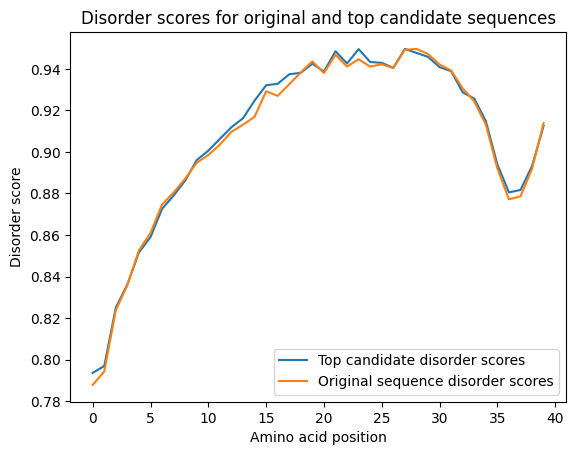

In [40]:
top_candidate_disorder_scores = meta.predict_disorder(top_candidate["ADseq"])
original_sequence_disorder_scores = meta.predict_disorder(protein_sequence)

plt.plot(top_candidate_disorder_scores, label="Top candidate disorder scores")
plt.plot(original_sequence_disorder_scores, label="Original sequence disorder scores")
plt.xlabel("Amino acid position")
plt.ylabel("Disorder score")
plt.title("Disorder scores for original and top candidate sequences")
plt.legend()
plt.show()


I believe what we can tell from this is that our top candidate here is likely to maintain the intrinsically disordered structure characteristic of functional activation domains. The plot above shows that the improved predicted activity did not come at the cost of order-disorder balance which is a good things and it might even hint at the possibility that slight modulation in specific regions could be beneficial

### Save Top 500 Sequences To CSV

In [ ]:
# Save the top 500 sequences to a CSV file
top_500 = sorted_disorder.head(500)
top_500.to_csv(f"top_500_sequences_{activity}.csv", index=False)